# Machine Learning for Demand Forecasting

Use case - Categorising libray contents from item description.

This is an unsupervised learning problem solved using a compination of TFIDF vectorising and the K-means clustering algorithm.

In [10]:
# sfOptions = {
#   "sfURL" : "datalytyx.east-us-2.azure.snowflakecomputing.com",
#   "sfAccount" : "datalytyx",
#   "sfUser" : "WILLHOLTAM",
#   "sfPassword" : "04MucSfLV",
#   "sfRole": "DATABRICKS",
#   "sfDatabase" : "DATABRICKS_DEMO",
#   "sfSchema" : "SEATTLE_LIBRARY",
#   "sfWarehouse" : "DATASCIENCE_WH"
# }
# SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

In [11]:
# #spark.conf.set("spark.executor.cores",2)

# df = spark.read.format(SNOWFLAKE_SOURCE_NAME) \
#   .options(**sfOptions) \
#   .option("query", """select * from library_collection_inventory where reportdate in ('2017-09-01T00:00:00','2017-10-01T00:00:00', '2017-11-01T00:00:00', '2017-12-01T00:00:00', '2018-01-01T00:00:00', '2018-01-01T00:00:00', '2018-02-01T00:00:00', '2018-02-01T00:00:00', '2018-03-01T00:00:00', '2018-04-01T00:00:00', '2018-05-01T00:00:00', '2018-06-01T00:00:00', '2018-07-01T00:00:00') """) \
#   .load().limit(1000)

In [12]:
# # Create a view or table

# temp_table_name = "library_collection_inventory"

# df.createOrReplaceTempView(temp_table_name)

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import nltk  # Has to be added through Workspaces/ attach library to cluster when using Databricks
import more_itertools
import re
import os
import codecs
import mpld3
import plotly as py
from matplotlib import pylab
from IPython.display import Image
from IPython.core.display import HTML
from snowflake.sqlalchemy import URL
from nltk.stem.snowball import SnowballStemmer
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.manifold import MDS

Log into plotly API

In [4]:
# user = "wil_hol"
# key = "ttoFQq1szuQ0bNadV1le"

# py.tools.set_credentials_file(username=user, api_key=key)

In [5]:
# df_pandas = df.toPandas()  # Create pandas dataframe to work within python when in Databricks

## Login to Snowflake

Set login parameters

In [6]:
sf_account = "datalytyx"
sf_user = "WILLHOLTAM"
sf_pwd = "04MucSfLV"
# sf_user = "CHRISSCHON"
# sf_pwd = "UpsetSheep7"
sf_role = "DATABRICKS"
sf_db = "DATABRICKS_DEMO"
sf_schema = "SEATTLE_LIBRARY"
sf_wh = "DATASCIENCE_WH"
sf_region = "east-us-2.azure"

Create Snowflake login URL

In [7]:
engine = create_engine(URL(
    user = sf_user,
    password = sf_pwd,
    account = sf_account,
    region = sf_region,
    database = sf_db,
    schema = sf_schema,
    warehouse = sf_wh,
    role = sf_role
))

Import Data from Snowflake as Pandas Dataframe

In [8]:
features = pd.read_sql_query(
    (
        "select * from library_collection_inventory where reportdate in (\
        '2017-09-01T00:00:00',\
        '2017-10-01T00:00:00',\
        '2017-11-01T00:00:00',\
        '2017-12-01T00:00:00',\
        '2018-01-01T00:00:00',\
        '2018-01-01T00:00:00',\
        '2018-02-01T00:00:00',\
        '2018-02-01T00:00:00',\
        '2018-03-01T00:00:00',\
        '2018-04-01T00:00:00',\
        '2018-05-01T00:00:00',\
        '2018-06-01T00:00:00',\
        '2018-07-01T00:00:00'\
        ) limit 10000"
    ), engine
)

In [9]:
features.head()

,bibnum,title,author,isbn,publicationyear,publisher,subjects,itemtype,itemcollection,floatingitem,itemlocation,reportdate,itemcount
0,2793009,The perfect gentleman : a Muslim boy meets the...,"Ahmad, Imran.","1455508497, 9781455508495",2012.,"Center Street,","Ahmad Imran Childhood and youth, Muslim boys E...",acbk,nanf,NA,lcy,2017-12-01T00:00:00,1
1,2683003,Leo the snow leopard : the true story of an am...,"Hatkoff, Juliana","0545229278, 9780545229272",2010.,"Scholastic Press,","New York Zoological Park Juvenile literature, ...",jcbk,ncnf,NA,swt,2017-12-01T00:00:00,1
2,751402,Designs for helicopters.,"Laskowitz, Isidor B., 1896-",None,[1947],"[Eastern Printing Co.],",Helicopters Patents,arbk,caaero,NA,cen,2017-12-01T00:00:00,1
3,3078119,Kidô keisatsu patorebâ = Patlabor : the mobile...,None,None,[2015],"Maiden Japan,","Robotics Japan Drama, Police Japan Drama, Toky...",acdvd,nalndvd,Floating,dlr,2017-12-01T00:00:00,1
4,2747381,Southeast Asia's best recipes : from Bangkok t...,"Hutton, Wendy","0804841667, 9780804841665",[2010],"Tuttle Pub.,","Cooking Southeast Asian, Cookbooks",acbk,nanf,NA,nhy,2017-12-01T00:00:00,1


Download stopwords and sentence tokenizer from NLTK

In [20]:
nltk.download('stopwords')  # Common words to ignore
nltk.download('punkt')  # Punkt Sentence Tokenizer - more useful in large documents

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WilliamHoltam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WilliamHoltam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load nltk's English stopwords as variable called 'stopwords'

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Load nltk's SnowballStemmer as variabled 'stemmer'.

Snowball is a small string processing language designed for creating stemming algorithms for use in Information Retrieval.

In [22]:
stemmer = SnowballStemmer("english")

Define the number of clusters to be used later in the model

In [23]:
num_clusters = 5

## Pre-processing Pipeline

This pipeline processes the original dataframe so that the datatypes in the columns of interest are correct. It removes both empty columns and rows containing NaN values

Note: Be careful to return a dataframe containing the same indexes and columns

In [24]:
class NoneReplacer(TransformerMixin, BaseEstimator):
    
    """
    Transformer changes Nonetype values into numpy NaN values.
    """
    
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self
        
    def transform(self, X):
        
        """
        Ttransform confirms X is a Dataframe and fills Nonetype with pd.np.nan
        """
        
        assert isinstance(X, pd.DataFrame)
        
        X.fillna(value = pd.np.nan, inplace=True)
        
        return pd.DataFrame(X, index = X.index, columns = X.columns)

In [25]:
# Testing

initiated_class = NoneReplacer()

initiated_class.fit(features)

df_pandas_fitter = initiated_class.transform(features)
# df_pandas_fitter

Removes empty columns from dataframe.

Note: Has to be in the fit as can't alter columns in Transform. Have to perform same columnwise opperations to both test and train data

In [26]:
class EmptyColumnRemover(TransformerMixin, BaseEstimator):
    
    """
    Transformer drops empty columns
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):  # has to take an optional y for pipelines
        
        """
        Fit Drops Columns where 100% of the column is Nonetype
        """
        
        self.drop_columns = features.isna().sum()[features.isna().sum() == X.shape[0]].index  # Calculates pd.series with column lables as indecies
        
        return self
        
    def transform(self, X):
        
        """
        Transform Confirms X is a DataFrame
        """
        
        assert isinstance(X, pd.DataFrame)
        
        return pd.DataFrame(X.drop(columns = self.drop_columns), index = X.index, columns = X.columns)

In [27]:
# Testing

initiated_class = EmptyColumnRemover()

initiated_class.fit(X=df_pandas_fitter)

df_pandas_fitter1 = initiated_class.transform(df_pandas_fitter)
# df_pandas_fitter1

A violent technique for dealing with NaNs - remove all rows containing NaNs, won't be appropriate for all usecases.

In [28]:
class AnyNaNRowRemover(TransformerMixin, BaseEstimator):
    
    """
    Transformer removes any rows where here any element in row is NaN
    """
    
    def __init__(self):
        pass
        
    def fit(self, X, y = None):  # has to take an optional y for pipelines
        return self
    
    def transform(self, X):
        
        """
        Transform drops rows where any element in row is NaN 
        """
        
        assert isinstance(X, pd.DataFrame)
        
        X = X.dropna(axis=0, how='any')
        
        self.cleaned_data = X
        
        return pd.DataFrame(X, index = X.index, columns = X.columns)

In [29]:
# Testing

initiated_class = AnyNaNRowRemover()

initiated_class.fit(df_pandas_fitter1)

df_pandas_fitter2 = initiated_class.transform(df_pandas_fitter1)

In [30]:
pre_processing_pipeline = Pipeline([
    ('nr', NoneReplacer()),
    ('ecr', EmptyColumnRemover()),
    ('anrr', AnyNaNRowRemover())
])

## Clustering Pipeline

This pipeline performs the steps necessary to perform K-means clustering on natural language data stored as text including Tokenizing, Stemming, TF-IDF-Vectorizing and K-means Clustering.

The result of TF-IDF-Vectorizing is as follows

<a <img src="http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402" width="350" height="350" border="0" /></a>

This class combines two processes:
    Tokenizing: Split sentences down into individual words.
    Stemming: The process of breaking a word down into its root.

In [31]:
class TokenizeAndStemer(TransformerMixin, BaseEstimator):
    
    """
    Transformer tokenizes and stems the words, creating a vocab dataframe 
    containing the words and their stems.
    """
    
    def __init__(self, text_column):
        self.text_column = text_column
        pass
    
    def tokenize_and_stem(self, text):
        
        """
        Function first Tokenizes and then Stems the words, returning the stems.
        """
        
        tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        
        filtered_tokens = []
        [filtered_tokens.append(token) if re.search('[a-zA-Z]', token) else token for token in tokens]
        
        stems = [stemmer.stem(t) for t in filtered_tokens]
        
        return stems
    
    def tokenize_only(self, text):
        
        """
        Function Tokenizes the words, returning tokens that are filtered to contain upper or
        lowwer case letters.
        """ 
        
        # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
        tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        [filtered_tokens.append(token) if re.search('[a-zA-Z]', token) else token for token in tokens]
                
        return filtered_tokens
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        """
        Transform applies both of the custom functions defined above.
        
        The tokenize_and_stem function us used to create a flat list 
        containing the entirity of the vocab in stemmed form. 
        
        The tokenize_only is used to create a flat list containing the
        entirity of the vocab as a flat list.
        
        A dataframe is created from both of these flat lists with the
        "words" column consisting of the individual words and the index
        consisting of the stems.
        
        Returns the feature of interest as a list
        """

        totalvocab_stemmed = []
        
        allwords_stemmed = [self.tokenize_and_stem(str(i)) for i in X[self.text_column].tolist()]  # for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed)
        totalvocab_stemmed = list(more_itertools.collapse(totalvocab_stemmed))
        
        totalvocab_tokenized = []

        allwords_tokenized = [self.tokenize_only(str(i)) for i in X[self.text_column].tolist()]  # for each item in 'synopses', tokenize/stem
        totalvocab_tokenized.extend(allwords_tokenized)
        totalvocab_tokenized = list(more_itertools.collapse(totalvocab_tokenized))        
 
        self.vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

        print('there are ' + str(self.vocab_frame.shape[0]) + ' items in vocab_frame')
        print(' ')
        print(self.vocab_frame.head())
        X = X[self.text_column].tolist()
        return X

In [32]:
#Testing

initiated_class = TokenizeAndStemer(text_column='subjects')

initiated_class.fit(df_pandas_fitter2)

df_pandas_fitter3 = initiated_class.transform(df_pandas_fitter2)

there are 101831 items in vocab_frame
 
                words
folklor      folklore
germani       germany
juvenil      juvenile
literatur  literature
fairi           fairy


In [33]:
class VectorCapture(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        self.tfidf_matrix = X
        
        return X

In [34]:
kwargs = {
    'max_df': 0.8,
    'max_features': 20000,
    'min_df': 0.001,
    'stop_words': 'english',
    'use_idf': True,
    'tokenizer': TokenizeAndStemer(text_column='subjects').tokenize_and_stem,
    'ngram_range': (1,3),
    'token_pattern': r"(?u)\b[\w-]+\b"
}

clustering_pipeline = Pipeline([
    ('tas', TokenizeAndStemer(text_column='subjects')),
    ('tfidf', TfidfVectorizer(**kwargs)),
    ('vc', VectorCapture()),
    ('km',KMeans(
        n_clusters=num_clusters,
        random_state=15)
    )
])

## Post-processing Pipeline

This pipeline appends the clusters to the original dataframe so that further analysis can be done and the attributes of each cluster can be investigated.

The top terms in each cluster are returned to the screen as an indicator of the topic/genre of each cluster.

In Future:
Want to Onehot encode the cluster categories and set the top terms as the column names for each cluster.

In [35]:
class DataFrameRebuild(TransformerMixin, BaseEstimator):

    """
    Transformer concatinates the cleaned dataframe after the pre-processing and
    the cluster categores as a new column.
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        """
        Transform concatinates the cleaned dataframe after the pre-processing and
        the cluster categores as a new column and returns the new 
        """
        
        self.clusters = clustering_pipeline.named_steps['km'].labels_.tolist()
        clusters_df = pd.DataFrame(self.clusters, columns = ['clusters'])
        clusters_df = clusters_df.set_index(pre_processing_pipeline.get_params(True)['anrr'].cleaned_data.index)
        
        cleaned_data = pre_processing_pipeline.get_params(True)['anrr'].cleaned_data
        
        result = pd.concat([cleaned_data, clusters_df], axis=1)
        
        result = result.set_index(
            keys = 'clusters',
            drop=False,
            append=False,
            inplace=False,
            verify_integrity=False
        )
        
        # frame.columns
        print(result.clusters.value_counts()) #number of items per cluster (clusters from 0 to 4)
        
        return result #pd.DataFrame(result, index = .index, columns = X.columns)  # df_clustering_output

In [36]:
#rom __future__ import print_function  # Print() becomes a function

class TopTerms(TransformerMixin, BaseEstimator):
    
    """
    Transformer prints out words closest to centre of each cluster.
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        """
        Transform returns the terms the tfidf matrix represents.
        Orders the cluster centers by proximity to centroid.
        Prints terms by proximity to centroid.
        """
        
        print("Top terms per cluster:")
        print()
        
        terms = clustering_pipeline.named_steps['tfidf'].get_feature_names()  # the terms tfidf matrix represents
        
        # sort cluster centers by proximity to centroid
        order_centroids = pd.DataFrame(
            clustering_pipeline.
            named_steps['km'].
            cluster_centers_.
            argsort()[:, ::-1]
        )
        
        self.top_terms_list = []
        
        for i in range(num_clusters):
            print("cluster %d words:" % i, end='')
            
            clustering_pipeline.get_params(True)['tas'].vocab_frame
            
            top_terms = []
            count = 0
            max_index = 6
            for ind in order_centroids.iloc[i, :max_index]:
                print(count)
                if count == max_index - 1:
                    print(' %s' % clustering_pipeline.
                          get_params(True)['tas'].
                          vocab_frame.
                          loc[terms[ind].split(' ')].
                          values.tolist()[0][0].
                          encode('utf-8', 'ignore')
                         )
                    
                    top_terms.append((
                        ' %s' % clustering_pipeline.
                        get_params(True)['tas'].
                        vocab_frame.
                        loc[terms[ind].split(' ')].
                        values.tolist()[0][0]  #.
    #                     encode('utf-8', 'ignore')
                    ).strip())
                    
                else:
                    print(' %s' % clustering_pipeline.
                          get_params(True)['tas'].
                          vocab_frame.
                          loc[terms[ind].split(' ')].
                          values.tolist()[0][0].
                          encode('utf-8', 'ignore'),
                          end=','
                         )
                    
                    top_terms.append((
                        ' %s' % clustering_pipeline.
                        get_params(True)['tas'].
                        vocab_frame.
                        loc[terms[ind].split(' ')].
                        values.tolist()[0][0] + ','#.
    #                     encode('utf-8', 'ignore')
                    ).strip())
            
                print() #add whitespace
                print() #add whitespace
                
                count += 1
                
#                 print("Cluster %d titles:" % i, end='')
# #                 for title in X.loc[i]['title'].values.tolist():
# #                     print(' %s,' % title, end='')
#                 print() #add whitespace
#                 print() #add whitespace
#                 top_terms = str[top_terms[:]]
            self.top_terms_list.append("".join(top_terms))
    
            print()
            print()
    
        return X

In [37]:
post_processing_pipeline = Pipeline([
    ('dfr', DataFrameRebuild()),
    ('tt', TopTerms())
])

## Model Pipeline

In [38]:
model_pipeline = Pipeline([
    ('pre_p_pipe', pre_processing_pipeline),
    ('c_pipe', clustering_pipeline),
    ('post_p_pipe', post_processing_pipeline)
])

result_df = model_pipeline.fit_transform(X = features)

there are 101831 items in vocab_frame
 
                words
folklor      folklore
germani       germany
juvenil      juvenile
literatur  literature
fairi           fairy


C:\Users\WilliamHoltam\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



0    2932
2    1507
1    1431
4     750
3     412
Name: clusters, dtype: int64
Top terms per cluster:

cluster 0 words:0
 b'states',

1
 b'united',

2
 b'united',

3
 b'history',

4
 b'biography',

5
 b'cooking'




cluster 1 words:0
 b'fiction',

1
 b'mystery',

2
 b'mystery',

3
 b'character',

4
 b'fictitious',

5
 b'women'




cluster 2 words:0
 b'fiction',

1
 b'juvenile',

2
 b'juvenile',

3
 b'stories',

4
 b'schools',

5
 b'friendship'




cluster 3 words:0
 b'comic',

1
 b'comic',

2
 b'books',

3
 b'comic',

4
 b'strips',

5
 b'books'




cluster 4 words:0
 b'juvenile',

1
 b'literature',

2
 b'juvenile',

3
 b'biography',

4
 b'biography',

5
 b'biography'






## Multidimentional Scaling

Note that the purpose of the MDS is to find a low-dimensional representation of the data (here 2D) in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seeks an isotropic representation of the data in the low-dimensional space. Here the manifold problem matches fairly that of representing a flat map of the Earth, as with map projection.

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(clustering_pipeline.named_steps['vc'].tfidf_matrix)

In [40]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [60]:
np.savetxt("mds.gz", pos)
# pos = np.loadtxt("mds.gz")  # To load data back in

## PCA

In [84]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD as SVD

svd = SVD()

cluster_pipe_reduced = svd.fit_transform(clustering_pipeline.named_steps['vc'].tfidf_matrix)

# PCA()

# pca = PCA(n_components=2, random_state=1)
# pca_answ = pca.fit_transform(clustering_pipeline.named_steps['vc'].tfidf_matrix)

[]

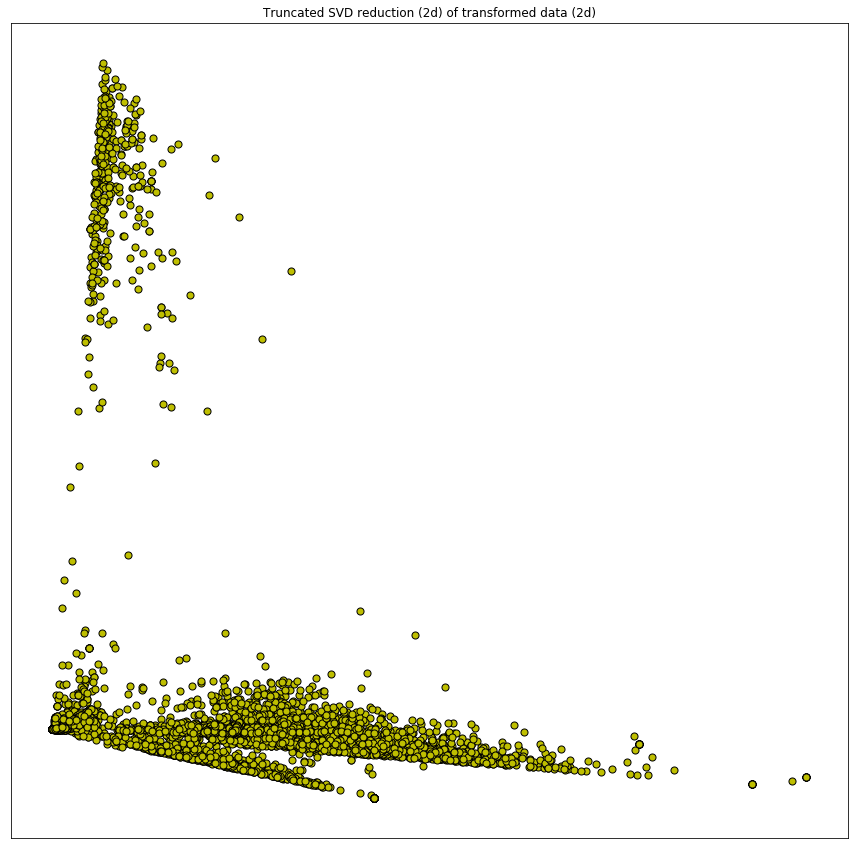

In [103]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.scatter(cluster_pipe_reduced[:, 0], cluster_pipe_reduced[:, 1], c="y", s=50, edgecolor='k')
ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" %
             cluster_pipe_reduced.shape[1])
ax.set_xticks(())
ax.set_yticks(())

## Visualisation

In [61]:
#set up colors per clusters using a dict
cluster_colors = {
#     0: '#1b9e77',
#     1: '#d95f02',
#     2: '#7570b3',
#     3: '#e7298a',
#     4: '#66a61e'
    0: 'deepskyblue',
    1: 'lightcoral',
    2: 'springgreen',
    3: 'orange',
    4: 'hotpink'
}

cluster_numbers = list(range(num_clusters))
cluster_description = post_processing_pipeline.named_steps['tt'].top_terms_list

cluster_names = dict(zip(cluster_numbers, cluster_description))

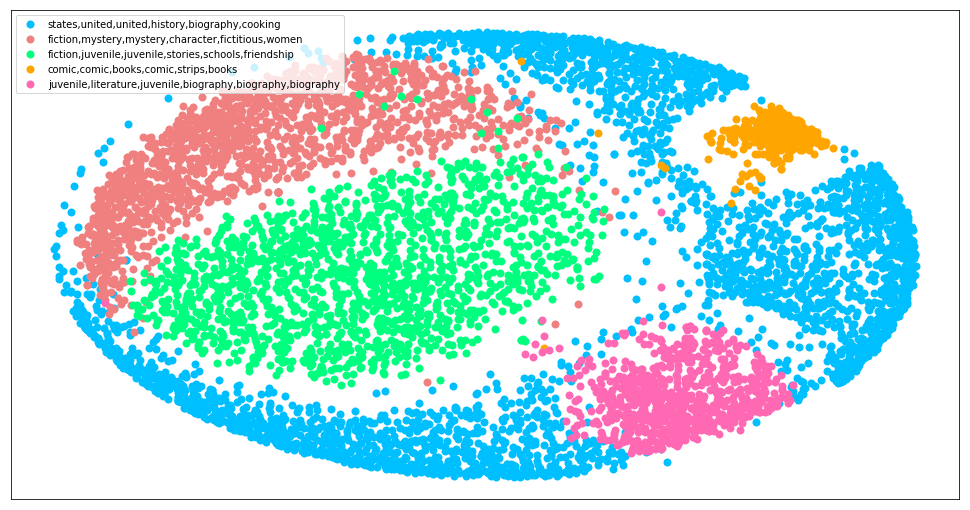

In [66]:
# some ipython magic to show the matplotlib plots inline
%matplotlib inline

# create data frame that has the result of the MDS plus the cluster numbers and titles

clusters = post_processing_pipeline.named_steps['dfr'].clusters
titles = pre_processing_pipeline.get_params(True)['anrr'].cleaned_data.title

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# print(df)

# group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:

    ax.plot(
        group.x,
        group.y,
        marker='o',
        linestyle='',
        ms=8,
        label=cluster_names[name],
        color=cluster_colors[name],
        mec='none'
    )

    ax.set_aspect('auto')

    ax.tick_params(
        axis= 'x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
    )

    ax.tick_params(
        axis= 'y',  # changes apply to the y-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelleft=False
    )

ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
    
# plt.savefig("visualisation.jpg")
# plt.show() #show the plot

# #uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=400)

The mpld3 project brings together Matplotlib, the popular Python-based graphing library, and D3js, the popular JavaScript library for creating interactive data visualizations for the web. The result is a simple API for exporting your matplotlib graphics to HTML code which can be used within the browser, within standard web pages, blogs, or tools such as the IPython notebook.

In [63]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 50);
      this.fig.toolbar.toolbar.attr("y", 100);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [65]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:"Arial Black", Gadget, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: 0px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,11)) #set plot size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    
    points = ax.plot(
        group.x,
        group.y,
        marker='o',
        linestyle='',
        ms=8, 
        label=cluster_names[name],
        mec='none', 
        color=cluster_colors[name]
    )
    
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax.patch.set_facecolor('white')

# plt.subplots_adjust(top = 0.75)      # the top of the subplots of the figure
# plt.xlim(-1,1.4)
plt.ylim(-1,1.1)
plt.tight_layout()
plt.legend(numpoints=1, loc='upper left', ncol=1, mode="expand", edgecolor=None)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(numpoints=1, loc=2) #show legend with only one dot
# plt.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure)

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)

# # file-output.py
# f = open('graph_html.htm','w')
# f.write(html)
# f.close()

# print(html)